# SWOT data exploration

In [2]:
%matplotlib widget

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from mpl_toolkits.mplot3d import Axes3D
from skimage import exposure
from skimage.io import imsave, imread
from osgeo import ogr
import pystac_client
from pyproj import Transformer
from datetime import date, timedelta, datetime
from dateutil.relativedelta import relativedelta
import geopandas as gpd
import pandas as pd
import geoviews as gv
import hvplot.pandas
import intake
import xarray as xr
import numpy as np
from numpy.random import default_rng
import intake
from pyproj import Proj, transform
from osgeo import gdal
from sklearn.neighbors import BallTree
import earthaccess
import datetime as dt

# for progress bar
from ipywidgets import IntProgress
from IPython.display import display
import time
from tqdm.notebook import trange, tqdm

import boto3
import rasterio as rio
from rasterio.features import rasterize
from rasterio.session import AWSSession
import dask
import os
import rioxarray
from rasterio.enums import Resampling
from rasterio.warp import reproject
from rasterio.warp import Resampling as resample
import cartopy.crs as ccrs
import cartopy
import scipy
import statsmodels.formula.api as smf
from shapely.geometry.polygon import Polygon, Point
import pygmt
import gc
import pytz
import pyproj
from pathlib import Path
import pprint

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Authenticate for boto S3 access, etc.
os.environ["AWS_REQUEST_PAYER"] = "requester"
aws_session = AWSSession(boto3.Session(), requester_pays=True)

In [4]:
# Authenticate for accessing NASA data (MODIS)
auth = earthaccess.login(strategy="netrc")

# If we are not authenticated
if not auth.authenticated:
    # Ask for credentials and persist them in a .netrc file
    auth.login(strategy="interactive", persist=True)

In [14]:
bbox = (-73,34,-68,38) # west, south, east, north
start_dt = '2024-07-01'
end_dt = '2024-07-30'

In [6]:
# Gather all files from search location from Terra and Aqua for the same day as the Landsat image
results = earthaccess.search_data(
    short_name='SWOT_L2_LR_SSH_UNSMOOTHED_2.0',
    bounding_box=bbox,
    # Day of a landsat scene to day after - searches day of only
    temporal=(start_dt, end_dt)
)
print (f'{len(results)} TOTAL granules')

Granules found: 25
25 TOTAL granules


In [13]:
# To image 1 day
ds = xr.open_dataset(earthaccess.open(results[0:2])[1], group='left',engine='h5netcdf')

# Adjust the longitude by subtracting 180
if 'longitude' in ds.coords:
    if ds['longitude'].max()>180:
        ds['longitude'] = ds['longitude'] - 180
elif 'lon' in ds.coords:
    if ds['lon'].max()>180:
        ds['lon'] = ds['lon'] - 180

# Create a mask for the desired latitude range
mask = (ds.longitude >= bbox[0]) & (ds.longitude <= bbox[2]) & (ds.latitude >= bbox[1]) & (ds.latitude <= bbox[3])
# Check if the mask is valid (non-empty)
if mask.sum() == 0:
    mask = (ds.longitude >= bbox[0]) & (ds.longitude <= bbox[2])
    if mask.sum() == 0:
        mask = (ds.latitude >= bbox[1]) & (ds.latitude <= bbox[3])
    
# Apply the mask to slice the dataset
ds_masked = ds.where(mask, drop=True)

# # Flatten the latitude and longitude coordinates
# lat = ds_masked.latitude.values.ravel()
# lon = ds_masked.longitude.values.ravel()
# ssh_karin_2 = ds_masked.ssh_karin_2.values.ravel()

# # Create a mask to filter out non-finite values
# mask = np.isfinite(lat) & np.isfinite(lon) & np.isfinite(ssh_karin_2)

# # Apply the mask to the data
# lat = lat[mask]
# lon = lon[mask]
# ssh_karin_2 = ssh_karin_2[mask]

Opening 2 granules, approx size: 1.39 GB
using endpoint: https://archive.swot.podaac.earthdata.nasa.gov/s3credentials


QUEUEING TASKS | :   0%|          | 0/2 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/2 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
fig,ax=plt.subplots(figsize=(8,5))
plot = ax.pcolormesh(ds_masked.longitude,ds_masked.latitude,ds_masked,cmap='coolwarm')
cbar = plt.colorbar(plot,ax=ax)

cbar.set_label('SLA', rotation=270)

ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')

plt.show()

## Multi-image processing

In [8]:
ds = xr.open_dataset(earthaccess.open(results[0:2])[0], group='left',engine='h5netcdf')
ds

Opening 2 granules, approx size: 1.34 GB
using endpoint: https://archive.swot.podaac.earthdata.nasa.gov/s3credentials


QUEUEING TASKS | :   0%|          | 0/2 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/2 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/2 [00:00<?, ?it/s]

<xarray.Dataset> Size: 2GB
Dimensions:                                (num_lines: 81607, num_pixels: 240)
Coordinates:
    latitude                               (num_lines, num_pixels) float64 157MB ...
    longitude                              (num_lines, num_pixels) float64 157MB ...
Dimensions without coordinates: num_lines, num_pixels
Data variables: (12/16)
    time                                   (num_lines) datetime64[ns] 653kB ...
    time_tai                               (num_lines) datetime64[ns] 653kB ...
    latitude_uncert                        (num_lines, num_pixels) float64 157MB ...
    longitude_uncert                       (num_lines, num_pixels) float64 157MB ...
    polarization_karin                     (num_lines) object 653kB ...
    ssh_karin_2                            (num_lines, num_pixels) float64 157MB ...
    ...                                     ...
    sig0_karin_uncert                      (num_lines, num_pixels) float32 78MB ...
    total_coherence                        (num_lines, num_pixels) float64 157MB ...
    mean_sea_surface_cnescls               (num_lines, num_pixels) float64 157MB ...
    miti_power_250m                        (num_lines, num_pixels) float32 78MB ...
    miti_power_var_250m                    (num_lines, num_pixels) float32 78MB ...
    ancillary_surface_classification_flag  (num_lines, num_pixels) float32 78MB ...
Attributes:
    description:  Unsmoothed SSH measurement data and related information for...

In [25]:
def swot_plot_prep(path,bbox):
    
    # Open left and right swaths
    dsl = xr.open_dataset(path, group='left',engine='h5netcdf')
    dsr = xr.open_dataset(path, group='right',engine='h5netcdf')
    
    # Concatenate the data, longitude and latitude coordinates
    ds = xr.concat([dsl['ssh_karin_2'], dsr['ssh_karin_2']], dim='num_lines')
    longitude = xr.concat([dsl['longitude'], dsr['longitude']], dim='num_lines')
    latitude = xr.concat([dsl['latitude'], dsr['latitude']], dim='num_lines')

    ds['date'] = [np.datetime_as_string(dsl.time[0], unit='D')]
    
    # Assign the concatenated coordinates back to the dataset
    ds = ds.assign_coords({
        'longitude': longitude,
        'latitude': latitude
    })
    
    if 'longitude' in ds.coords:
        if ds['longitude'].max()>180:
            ds['longitude'] = ds['longitude'] - 180
    elif 'lon' in ds.coords:
        if ds['lon'].max()>180:
            ds['lon'] = ds['lon'] - 180
    
    # Create a mask for the desired latitude range
    mask = (ds.longitude >= bbox[0]) & (ds.longitude <= bbox[2]) & (ds.latitude >= bbox[1]) & (ds.latitude <= bbox[3])
    print(mask.sum())
    # Check if the mask is valid (non-empty)
    if mask.sum() == 0:
        mask = (ds.longitude >= bbox[0]) & (ds.longitude <= bbox[2])
        if mask.sum() == 0:
            print('Mask via longitude only')
            mask = (ds.latitude >= bbox[1]) & (ds.latitude <= bbox[3])
            print(mask.sum())
        else:
            print('Mask via latitude only')
            print(mask.sum())
        
    # Apply the mask to slice the dataset
    ds_masked = ds.where(mask, drop=True)

    return ds_masked

In [ ]:
paths = earthaccess.open(results)

In [19]:
# Adjust the longitude by subtracting 180
i=1

dsl = xr.open_dataset(paths[i], group='left',engine='h5netcdf')
dsr = xr.open_dataset(paths[i], group='right',engine='h5netcdf')

# Concatenate the data, longitude and latitude coordinates
ds = xr.concat([dsl['ssh_karin_2'], dsr['ssh_karin_2']], dim='num_lines')
longitude = xr.concat([dsl['longitude'], dsr['longitude']], dim='num_lines')
latitude = xr.concat([dsl['latitude'], dsr['latitude']], dim='num_lines')

ds['date'] = [np.datetime_as_string(dsl.time[0], unit='D')]

# Assign the concatenated coordinates back to the dataset
ds = ds.assign_coords({
    'longitude': longitude,
    'latitude': latitude
})

if 'longitude' in ds.coords:
    if ds['longitude'].max()>180:
        ds['longitude'] = ds['longitude'] - 180
elif 'lon' in ds.coords:
    if ds['lon'].max()>180:
        ds['lon'] = ds['lon'] - 180

# Create a mask for the desired latitude range
mask = (ds.longitude >= bbox[0]) & (ds.longitude <= bbox[2]) & (ds.latitude >= bbox[1]) & (ds.latitude <= bbox[3])
print(mask.sum())
# Check if the mask is valid (non-empty)
if mask.sum() == 0:
    mask = (ds.longitude >= bbox[0]) & (ds.longitude <= bbox[2])
    if mask.sum() == 0:
        print('Mask via longitude only')
        mask = (ds.latitude >= bbox[1]) & (ds.latitude <= bbox[3])
        print(mask.sum())
    else:
        print('Mask via latitude only')
        print(mask.sum())
    
# Apply the mask to slice the dataset
ds_masked = ds.where(mask, drop=True)

Opening 2 granules, approx size: 1.39 GB
using endpoint: https://archive.swot.podaac.earthdata.nasa.gov/s3credentials


QUEUEING TASKS | :   0%|          | 0/2 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/2 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/2 [00:00<?, ?it/s]

Opening 2 granules, approx size: 1.39 GB
using endpoint: https://archive.swot.podaac.earthdata.nasa.gov/s3credentials


QUEUEING TASKS | :   0%|          | 0/2 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/2 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/2 [00:00<?, ?it/s]

<xarray.DataArray ()> Size: 8B
array(0)
Mask via longitude only
<xarray.DataArray 'latitude' ()> Size: 8B
array(894665)


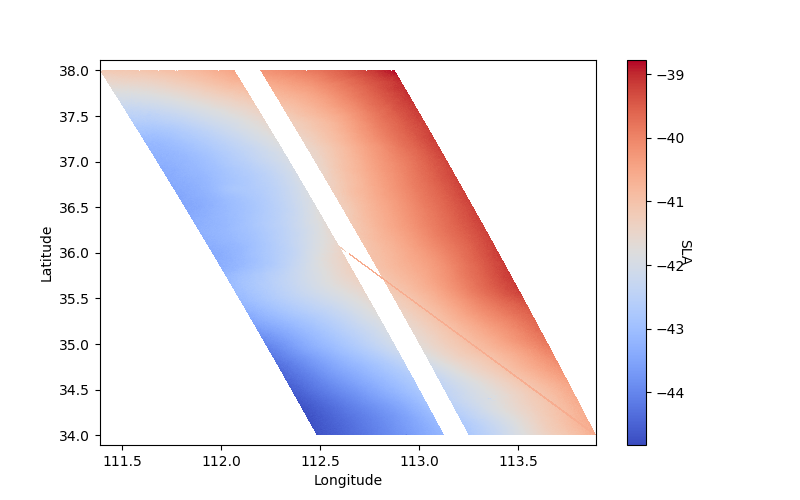

In [20]:
fig,ax=plt.subplots(figsize=(8,5))
plot = ax.pcolormesh(ds_masked.longitude,ds_masked.latitude,ds_masked,cmap='coolwarm')
cbar = plt.colorbar(plot,ax=ax)

cbar.set_label('SLA', rotation=270)

ax.set_ylabel('Latitude')
ax.set_xlabel('Longitude')

plt.show()

In [26]:
# To image multiple days

paths = earthaccess.open(results)

# Construct xarray for scene
days = []
for path in paths[0:3]:
    ds = swot_plot_prep(path,bbox)
    days.append(ds)
    print(i)
swot = xr.concat(days, dim='date')
# ls_scene.coords['id'] = sceneid.id
# ls_scene.coords['time'] = item.metadata['datetime'].strftime('%Y-%m-%dT%H:%M:%S')
# ls_scene = ls_scene['band_data']

Opening 25 granules, approx size: 15.74 GB
using endpoint: https://archive.swot.podaac.earthdata.nasa.gov/s3credentials


QUEUEING TASKS | :   0%|          | 0/25 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/25 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/25 [00:00<?, ?it/s]

ValueError: cannot add coordinates with new dimensions to a DataArray

In [62]:
mask = (ds.latitude >= bbox[1]) & (ds.latitude <= bbox[3])
mask.sum()

<xarray.DataArray 'latitude' ()> Size: 8B
array(454938)

In [82]:
# Working
ds1 = xr.open_mfdataset(earthaccess.open(results[0:3]), combine='nested', concat_dim="num_lines", decode_times=False, group='left',engine='h5netcdf')
ds2 = xr.open_mfdataset(earthaccess.open(results[0:3]), combine='nested', concat_dim="num_lines", decode_times=False, group='right',engine='h5netcdf')
ds2

Opening 3 granules, approx size: 2.06 GB
using endpoint: https://archive.swot.podaac.earthdata.nasa.gov/s3credentials


QUEUEING TASKS | :   0%|          | 0/3 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/3 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/3 [00:00<?, ?it/s]

Opening 3 granules, approx size: 2.06 GB
using endpoint: https://archive.swot.podaac.earthdata.nasa.gov/s3credentials


QUEUEING TASKS | :   0%|          | 0/3 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/3 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/3 [00:00<?, ?it/s]

<xarray.Dataset> Size: 6GB
Dimensions:                                (num_lines: 248013, num_pixels: 240)
Coordinates:
    latitude                               (num_lines, num_pixels) float64 476MB dask.array<chunksize=(16407, 48), meta=np.ndarray>
    longitude                              (num_lines, num_pixels) float64 476MB dask.array<chunksize=(16407, 48), meta=np.ndarray>
Dimensions without coordinates: num_lines, num_pixels
Data variables: (12/16)
    time                                   (num_lines) float64 2MB dask.array<chunksize=(82035,), meta=np.ndarray>
    time_tai                               (num_lines) float64 2MB dask.array<chunksize=(82035,), meta=np.ndarray>
    latitude_uncert                        (num_lines, num_pixels) float64 476MB dask.array<chunksize=(20509, 60), meta=np.ndarray>
    longitude_uncert                       (num_lines, num_pixels) float64 476MB dask.array<chunksize=(20509, 60), meta=np.ndarray>
    polarization_karin                     (num_lines) object 2MB dask.array<chunksize=(82035,), meta=np.ndarray>
    ssh_karin_2                            (num_lines, num_pixels) float64 476MB dask.array<chunksize=(16407, 48), meta=np.ndarray>
    ...                                     ...
    sig0_karin_uncert                      (num_lines, num_pixels) float32 238MB dask.array<chunksize=(16407, 48), meta=np.ndarray>
    total_coherence                        (num_lines, num_pixels) float64 476MB dask.array<chunksize=(20509, 60), meta=np.ndarray>
    mean_sea_surface_cnescls               (num_lines, num_pixels) float64 476MB dask.array<chunksize=(16407, 48), meta=np.ndarray>
    miti_power_250m                        (num_lines, num_pixels) float32 238MB dask.array<chunksize=(16407, 48), meta=np.ndarray>
    miti_power_var_250m                    (num_lines, num_pixels) float32 238MB dask.array<chunksize=(16407, 48), meta=np.ndarray>
    ancillary_surface_classification_flag  (num_lines, num_pixels) float32 238MB dask.array<chunksize=(27345, 80), meta=np.ndarray>
Attributes:
    description:  Unsmoothed SSH measurement data and related information for...

In [8]:
# ds['ssha_karin_corrected'] = ds.ssh_karin_2 + ds.height_cor_xover
# ds.ssha_karin_corrected

In [85]:
minlat,maxlat = bbox[1],bbox[3]
# sshL,latL,lonL = swot_plot_prep(ds1,minlat,maxlat)
# sshR,latR,lonR = swot_plot_prep(ds2,minlat,maxlat)
ds1 = swot_plot_prep(ds1,minlat,maxlat)
ds2 = swot_plot_prep(ds2,minlat,maxlat)

In [87]:
ds1

<xarray.Dataset> Size: 176MB
Dimensions:                                (num_lines: 5917, num_pixels: 240)
Coordinates:
    latitude                               (num_lines, num_pixels) float64 11MB ...
    longitude                              (num_lines, num_pixels) float64 11MB ...
Dimensions without coordinates: num_lines, num_pixels
Data variables: (12/16)
    time                                   (num_lines, num_pixels) float64 11MB dask.array<chunksize=(1978, 240), meta=np.ndarray>
    time_tai                               (num_lines, num_pixels) float64 11MB dask.array<chunksize=(1978, 240), meta=np.ndarray>
    latitude_uncert                        (num_lines, num_pixels) float64 11MB dask.array<chunksize=(1978, 60), meta=np.ndarray>
    longitude_uncert                       (num_lines, num_pixels) float64 11MB dask.array<chunksize=(1978, 60), meta=np.ndarray>
    polarization_karin                     (num_lines, num_pixels) object 11MB dask.array<chunksize=(1978, 240), meta=np.ndarray>
    ssh_karin_2                            (num_lines, num_pixels) float64 11MB dask.array<chunksize=(1978, 48), meta=np.ndarray>
    ...                                     ...
    sig0_karin_uncert                      (num_lines, num_pixels) float32 6MB dask.array<chunksize=(1978, 48), meta=np.ndarray>
    total_coherence                        (num_lines, num_pixels) float64 11MB dask.array<chunksize=(1978, 60), meta=np.ndarray>
    mean_sea_surface_cnescls               (num_lines, num_pixels) float64 11MB dask.array<chunksize=(1978, 48), meta=np.ndarray>
    miti_power_250m                        (num_lines, num_pixels) float32 6MB dask.array<chunksize=(1978, 48), meta=np.ndarray>
    miti_power_var_250m                    (num_lines, num_pixels) float32 6MB dask.array<chunksize=(1978, 48), meta=np.ndarray>
    ancillary_surface_classification_flag  (num_lines, num_pixels) float32 6MB dask.array<chunksize=(1978, 80), meta=np.ndarray>
Attributes:
    description:  Unsmoothed SSH measurement data and related information for...

In [52]:
bbox[0],bbox[1],bbox[2],bbox[3]

(-73, 34, -68, 38)

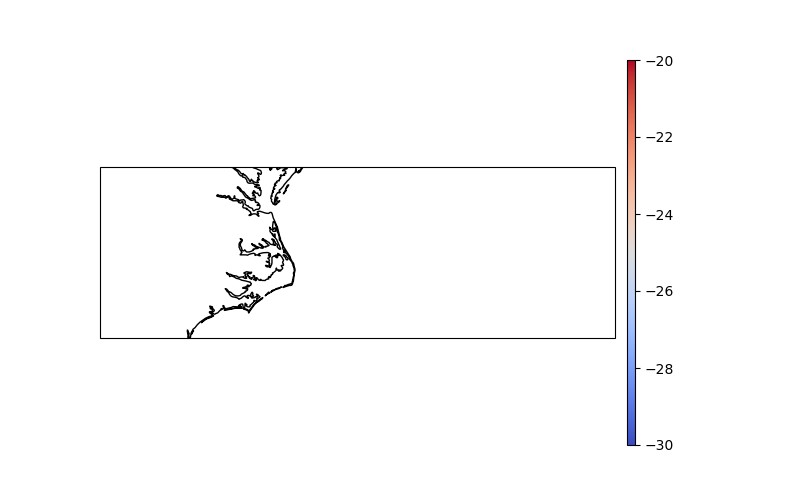

In [54]:
# Plot the cleaned data
plt.figure(figsize=(8, 5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()

# Set the latitude and longitude limits
ax.set_extent([bbox[0],bbox[2],bbox[1],bbox[3]], crs=ccrs.PlateCarree())

# Use pcolormesh to plot the cleaned data
data,lat,lon = ssh_karin_2,lat,lon
p = ax.scatter(
    lon, lat, c=data,
    transform=ccrs.PlateCarree(), vmin=-30, vmax=-20, cmap='coolwarm', s=1
)

# data,lat,lon = sshR,latR,lonR
# ax.scatter(
#     lon, lat, c=data,
#     transform=ccrs.PlateCarree(), vmin=-30, vmax=-20, cmap='coolwarm', s=1
# )

# Add colorbar
plt.colorbar(p, ax=ax, orientation='vertical', pad=0.02, aspect=50)

# Add coastlines
ax.coastlines()

# Display the plot
plt.show()

# Test code

In [5]:
#retrieves granule from the day we want
karin_results = earthaccess.search_data(short_name = 'SWOT_L2_LR_SSH_EXPERT_2.0', 
                                        bounding_box=bbox, 
                                        temporal=(start_dt, end_dt))

Granules found: 21


In [6]:
#opens granules and load into xarray dataset
ds = xr.open_mfdataset(earthaccess.open(karin_results[0:12]), combine='nested', concat_dim="num_lines", decode_times=False, engine='h5netcdf')
ds

Opening 12 granules, approx size: 0.39 GB
using endpoint: https://archive.swot.podaac.earthdata.nasa.gov/s3credentials


QUEUEING TASKS | :   0%|          | 0/12 [00:00<?, ?it/s]

PROCESSING TASKS | :   0%|          | 0/12 [00:00<?, ?it/s]

COLLECTING RESULTS | :   0%|          | 0/12 [00:00<?, ?it/s]

<xarray.Dataset> Size: 5GB
Dimensions:                                (num_lines: 118392, num_pixels: 69,
                                            num_sides: 2)
Coordinates:
    latitude                               (num_lines, num_pixels) float64 65MB dask.array<chunksize=(9866, 69), meta=np.ndarray>
    longitude                              (num_lines, num_pixels) float64 65MB dask.array<chunksize=(9866, 69), meta=np.ndarray>
    latitude_nadir                         (num_lines) float64 947kB dask.array<chunksize=(9866,), meta=np.ndarray>
    longitude_nadir                        (num_lines) float64 947kB dask.array<chunksize=(9866,), meta=np.ndarray>
Dimensions without coordinates: num_lines, num_pixels, num_sides
Data variables: (12/98)
    time                                   (num_lines) float64 947kB dask.array<chunksize=(9866,), meta=np.ndarray>
    time_tai                               (num_lines) float64 947kB dask.array<chunksize=(9866,), meta=np.ndarray>
    ssh_karin                              (num_lines, num_pixels) float64 65MB dask.array<chunksize=(9866, 69), meta=np.ndarray>
    ssh_karin_qual                         (num_lines, num_pixels) float64 65MB dask.array<chunksize=(9866, 69), meta=np.ndarray>
    ssh_karin_uncert                       (num_lines, num_pixels) float64 65MB dask.array<chunksize=(9866, 69), meta=np.ndarray>
    ssha_karin                             (num_lines, num_pixels) float64 65MB dask.array<chunksize=(9866, 69), meta=np.ndarray>
    ...                                     ...
    swh_ssb_cor_source                     (num_lines, num_pixels) float32 33MB dask.array<chunksize=(9866, 69), meta=np.ndarray>
    swh_ssb_cor_source_2                   (num_lines, num_pixels) float32 33MB dask.array<chunksize=(9866, 69), meta=np.ndarray>
    wind_speed_ssb_cor_source              (num_lines, num_pixels) float32 33MB dask.array<chunksize=(9866, 69), meta=np.ndarray>
    wind_speed_ssb_cor_source_2            (num_lines, num_pixels) float32 33MB dask.array<chunksize=(9866, 69), meta=np.ndarray>
    volumetric_correlation                 (num_lines, num_pixels) float64 65MB dask.array<chunksize=(9866, 69), meta=np.ndarray>
    volumetric_correlation_uncert          (num_lines, num_pixels) float64 65MB dask.array<chunksize=(9866, 69), meta=np.ndarray>
Attributes: (12/62)
    Conventions:                                   CF-1.7
    title:                                         Level 2 Low Rate Sea Surfa...
    institution:                                   CNES
    source:                                        Ka-band radar interferometer
    history:                                       2024-01-05T21:19:25Z : Cre...
    platform:                                      SWOT
    ...                                            ...
    ellipsoid_semi_major_axis:                     6378137.0
    ellipsoid_flattening:                          0.0033528106647474805
    good_ocean_data_percent:                       64.08514221672752
    ssha_variance:                                 1.3903190024565364
    references:                                    V1.2.1
    equator_longitude:                             -49.14

In [7]:
ds['ssh_karin_2_corrected'] = ds.ssh_karin_2 + ds.height_cor_xover
ds['ssha_karin_corrected'] = ds.ssha_karin + ds.height_cor_xover
ds.ssh_karin_2_corrected

<xarray.DataArray 'ssh_karin_2_corrected' (num_lines: 118392, num_pixels: 69)> Size: 65MB
dask.array<add, shape=(118392, 69), dtype=float64, chunksize=(9866, 69), chunktype=numpy.ndarray>
Coordinates:
    latitude         (num_lines, num_pixels) float64 65MB dask.array<chunksize=(9866, 69), meta=np.ndarray>
    longitude        (num_lines, num_pixels) float64 65MB dask.array<chunksize=(9866, 69), meta=np.ndarray>
    latitude_nadir   (num_lines) float64 947kB dask.array<chunksize=(9866,), meta=np.ndarray>
    longitude_nadir  (num_lines) float64 947kB dask.array<chunksize=(9866,), meta=np.ndarray>
Dimensions without coordinates: num_lines, num_pixels

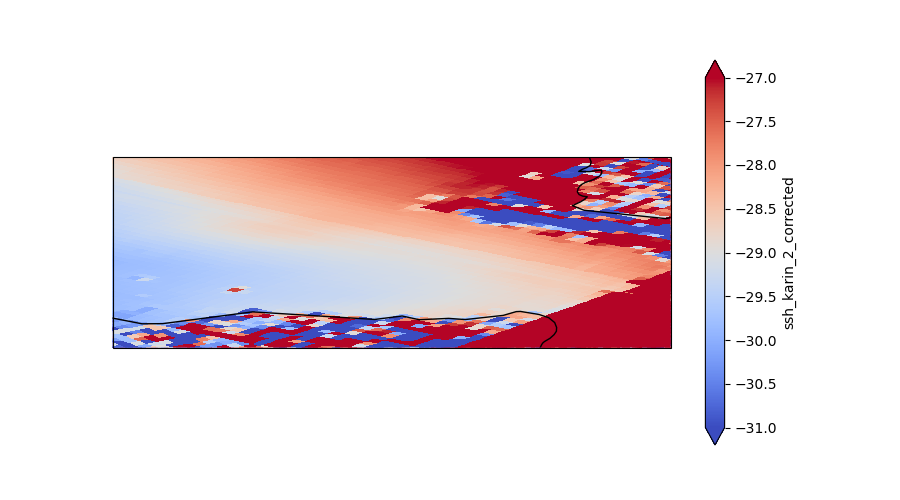

In [13]:
plt.figure(figsize=(9, 5))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.set_global()

# Set the latitude and longitude limits
# ax.set_extent([-110, -99, -75.44, -71], crs=ccrs.PlateCarree())
ax.set_extent([-104.1, -100.9, -75.29, -74.2], crs=ccrs.PlateCarree())

ds.ssh_karin_2_corrected.plot.pcolormesh(
 ax=ax, transform=ccrs.PlateCarree(), x="longitude", y="latitude", vmin=-31, vmax=-27, cmap='coolwarm', add_colorbar=True
) # vmin=-12, vmax=5,
ax.coastlines()